# Sentiment Classification & How To "Frame Problems" for a Neural Network

by Andrew Trask

- **Twitter**: @iamtrask
- **Blog**: http://iamtrask.github.io

In [1]:
import os
import sys
import math
import logging
from pathlib import Path
import numpy as np

import torch.optim as optim
import torch
from torchvision import transforms, models

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
from sentiment_analysis.sentiment import pretty_print_review_and_label, update_input_layer, get_target_for_label

# Curate a Dataset

In [3]:
data_path = "../data/raw/Sentiment analysis"
review_path = os.path.join(data_path, 'reviews.txt')
label_path = os.path.join(data_path, 'labels.txt')

# Open reviews and labels
g = open(review_path,'r') 
reviews = list(map(lambda x:x[:-1],g.readlines()))
g.close()

g = open(label_path,'r') 
labels = list(map(lambda x:x[:-1].upper(),g.readlines()))
g.close()

In [4]:
len(reviews)

25000

In [5]:
reviews[0]

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   '

In [6]:
labels[0]

'POSITIVE'

# Develop a Predictive Theory

In [7]:
print("labels.txt \t : \t reviews.txt\n")
pretty_print_review_and_label(2137,labels, reviews)
pretty_print_review_and_label(12816,labels, reviews)
pretty_print_review_and_label(6267,labels, reviews)
pretty_print_review_and_label(21934,labels, reviews)
pretty_print_review_and_label(5297,labels, reviews)
pretty_print_review_and_label(4998,labels, reviews)

labels.txt 	 : 	 reviews.txt

NEGATIVE	:	this movie is terrible but it has some good effects .  ...
POSITIVE	:	adrian pasdar is excellent is this film . he makes a fascinating woman .  ...
NEGATIVE	:	comment this movie is impossible . is terrible  very improbable  bad interpretat...
POSITIVE	:	excellent episode movie ala pulp fiction .  days   suicides . it doesnt get more...
NEGATIVE	:	if you haven  t seen this  it  s terrible . it is pure trash . i saw this about ...
POSITIVE	:	this schiffer guy is a real genius  the movie is of excellent quality and both e...


# Theory Validation

In [10]:
from collections import Counter

In [11]:
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

In [12]:
for i in range(len(reviews)):
    if (labels[i] == 'POSITIVE'):
        for word in reviews[i].split(' '):
            positive_counts[word] += 1
            total_counts[word] += 1
    else:
        for word in reviews[i].split(' '):
            negative_counts[word] += 1
            total_counts[word] += 1

In [13]:
pos_neg_ratios = Counter()

for term, cnt in list(total_counts.most_common()):
    if (cnt > 300):
        pos_neg_ratios[term] = positive_counts[term] / float(negative_counts[term] + 1)
        
for word, ratio in pos_neg_ratios.most_common():
    if (ratio > 1):
        pos_neg_ratios[word] = np.log(ratio)
    else:
        pos_neg_ratios[word] = -np.log((1 / (ratio + 0.01)))

In [14]:
# words most frequently seen in a review with "POSITIVE" label
pos_neg_ratios.most_common()[:7]

[('wonderfully', 2.0218960560332353),
 ('beautifully', 1.7626953362841438),
 ('superb', 1.7091514458966952),
 ('touching', 1.637217476541176),
 ('stewart', 1.611998733295774),
 ('wonderful', 1.5645425925262093),
 ('fantastic', 1.5048433868558566)]

In [15]:
# words most frequently seen in a review with a "NEGATIVE" label
list(reversed(pos_neg_ratios.most_common()))[:7]

[('waste', -2.4907515123361046),
 ('pointless', -2.345107387713634),
 ('redeeming', -2.2667790015910296),
 ('worst', -2.1930856334332267),
 ('laughable', -2.172468615469592),
 ('awful', -2.1385076866397488),
 ('poorly', -2.132613384420701)]

In [56]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [57]:
hist, edges = np.histogram(list(map(lambda x:x[1],pos_neg_ratios.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="Word Positive/Negative Affinity Distribution")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

C:\Users\hidalg89\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The normed argument is ignored when density is provided. In future passing both will result in an error.
  """Entry point for launching an IPython kernel.


In [58]:
frequency_frequency = Counter()

for word, cnt in total_counts.most_common():
    frequency_frequency[cnt] += 1

In [59]:
hist, edges = np.histogram(list(map(lambda x:x[1],frequency_frequency.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="The frequency distribution of the words in our corpus")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

C:\Users\hidalg89\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The normed argument is ignored when density is provided. In future passing both will result in an error.
  """Entry point for launching an IPython kernel.


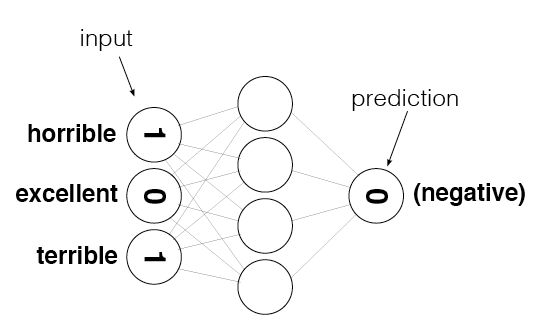

In [16]:
from IPython.display import Image

review = "This was a horrible, terrible movie."
Image(filename='../notebook_images/sentiment_network.png')

# Neural Network

In [62]:
from sentiment_analysis.sentiment import SentimentNetwork

In [63]:
net = SentimentNetwork(reviews[:-1000],labels[:-1000],min_count=20,polarity_cutoff=0.05,learning_rate=0.01)

In [64]:
net.train(reviews[:-1000], labels[:-1000])

Progress:99.9% Speed(reviews/sec):1384. #Correct:20461 #Trained:24000 Training Accuracy:85.2%

In [68]:
net.test(reviews[-1000:], labels[-1000:])

Progress:99.9% Speed(reviews/sec):2378.% #Correct:859 #Tested:1000 Testing Accuracy:85.9%

In [81]:
mlp_full = SentimentNetwork(reviews[:-1000],labels[:-1000],min_count=0,polarity_cutoff=0,learning_rate=0.01)

In [82]:
mlp_full.train(reviews[:-1000],labels[:-1000])

Progress:99.9% Speed(reviews/sec):1575. #Correct:20335 #Trained:24000 Training Accuracy:84.7%

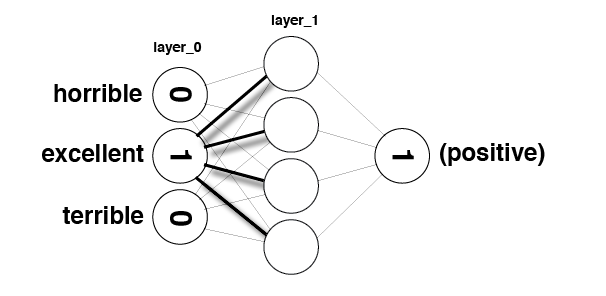

In [70]:
Image(filename='../notebook_images/sentiment_network_sparse.png')

In [89]:
def get_most_similar_words(focus = "horrible"):
    most_similar = Counter()

    for word in mlp_full.word2index.keys():
        most_similar[word] = np.dot(mlp_full.weights_0_1[mlp_full.word2index[word]],mlp_full.weights_0_1[mlp_full.word2index[focus]])
    
    return most_similar.most_common()

In [90]:
get_most_similar_words("excellent")[:5]

[('excellent', 0.13672950757352473),
 ('perfect', 0.12548286087225946),
 ('amazing', 0.0918276339259997),
 ('today', 0.0902236626944142),
 ('wonderful', 0.08935597696221463)]

In [91]:
get_most_similar_words("terrible")[:5]

[('worst', 0.16966107259049845),
 ('awful', 0.12026847019691245),
 ('waste', 0.11945367265311004),
 ('poor', 0.0927588875744355),
 ('terrible', 0.09142538719772794)]

In [92]:
import matplotlib.colors as colors

words_to_visualize = list()
for word, ratio in pos_neg_ratios.most_common(500):
    if(word in mlp_full.word2index.keys()):
        words_to_visualize.append(word)
    
for word, ratio in list(reversed(pos_neg_ratios.most_common()))[0:500]:
    if(word in mlp_full.word2index.keys()):
        words_to_visualize.append(word)

In [93]:
pos = 0
neg = 0

colors_list = list()
vectors_list = list()
for word in words_to_visualize:
    if word in pos_neg_ratios.keys():
        vectors_list.append(mlp_full.weights_0_1[mlp_full.word2index[word]])
        if(pos_neg_ratios[word] > 0):
            pos+=1
            colors_list.append("#00ff00")
        else:
            neg+=1
            colors_list.append("#000000")
    

In [94]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(vectors_list)

In [98]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="vector T-SNE for most polarized words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_to_visualize,
                                    color=colors_list))

p.scatter(x="x1", y="x2", size=8, source=source, fill_color="color")

word_labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(word_labels)

show(p)

# green indicates positive words, black indicates negative words